# Queue code

This is the code of the FIFO Queue Basic Model for High Frequency Trading, solved with Monte Carlo and Quasi Monte Carlo Methods.

## Changes:
* The variables should be as they're in the principal document.
* The intervals are writen with two decimals in format sol +/- range.
* The log axis starts with 1 instead of 0.
* In plots there are wo lines to show the confidence interval instead of the solution.
* There's a list of concepts in the beginning.
* The code has more comments, it is better explained.

## Concepts
* Scenarios (M): Number of times the reality is simulated. In option pricing this would be each path.
* Batches (K): Number of subsequences the random or low discrepancy sequence is splitted. For example, in option pricing, a path with 30 days could be splitted in 6 batches of 5 points.
* Amount of Events per Scenario (N): Maximum number of Events in one Scenario. In option pricing is fixed to the number of points per path. Here the path could be infinite so we have to put a limit.
* Amount of numbers per Batch (J): Points in each subsequence. As the example of the batch.
* Experiments (Experiments): Number of times a MC or QMC is finished. This is used to obtain the confidence interval.

Here we import the libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qmcpy as qp
import math

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

print("done")

done


Here we have a function that takes a number and gives you the next power of two. It is used for Digital Nets in Base 2 sequences.

In [2]:
def pot2(num):
    pot = math.ceil(math.log2(num))  # Encuentra el exponente de la potencia de 2 más cercana
    pot2 = 2 ** pot # Calcula la potencia de 2 correspondiente
    return pot2

print("done")

done


Here we have the queue function. You have to introduce the number of batches (K), the number of scenarios (N), the type of QMC or MC method (rv_type) and a variable to print the result or not print it (print1). It returns the solution over the iterations (mean_table) and all the solutions (t_table) for each scenario and iteration, so you can make a histogram.

In [3]:
def queue(M, K, rv_type, print1):
    
    # To avoid errors
    M = int(M) # Number of scenarios
    K = int(K) # Number of batches
    
    Px = 0.2 # Probability of execution
    Pc = 0.3 # Probability of cancellation
    Pa = 0.5 # Probability of addition
    bs = 2.7 # average size of the order
    Q0 = 31 # initial lenght of the queue
    q0 = 31 # initial position of our order
    
    
    N = 120 # The maximum number of orders allowed to being executed
    
    
    t_table = [] # the number of events for being executed in all scenarios
    mean_table = [] # the cumulative average number of events for being executed in each scenario
  

    # Here is chosen the MC or QMC Method:
    if rv_type == 'MC':
        # Normal MC
        rv = np.random.uniform(0, 1, size = [pot2(M), 3*N]) # In MC is not necessary to do this but I do it to compare it fairly with DN2
               
    elif rv_type == 'QMC_Lat':
        # Lattice random variable generation
        lat = qp.Lattice(3*N)
        rv = lat.gen_samples(M)
                
    elif rv_type == 'QMC_DN2':
        # Digital Net random variable generation
        dig = qp.DigitalNetB2(3*N)
        rv = dig.gen_samples(pot2(M))
        
    elif rv_type == 'QMC_Lat_Batch':
        # Lattice random variable generation
        N_batch = int(3*N/K)
        lat = qp.Lattice(N_batch)
        rv = lat.gen_samples(pot2(M)) # In Lattice is not necessary to do this but I do it to compare it fairly with DN2
        for ii in range(K-1):
            lat = qp.Lattice(N_batch)
            rv = np.concatenate((rv, lat.gen_samples(pot2(M))), 1)
        
    elif rv_type == 'QMC_DN2_Batch':
        # Digital Net random variable generation
        N_batch = int(3*N/K)
        dig = qp.DigitalNetB2(N_batch)
        rv = dig.gen_samples(pot2(M))
        for ii in range(K-1):
            dig = qp.DigitalNetB2(N_batch)
            rv = np.concatenate((rv, dig.gen_samples(pot2(M))), 1)
    
    else:
        print('error: Method type non valid')
    
    for ii in range(0, M): # ii is the number the scenario

        q = q0
        Q = Q0
        
        
        for t in range(0, N): # t is an auxiliar variable to use the sequences generated
            rv0 = rv[ii][3*t] # choosing the type of action
            rv1 = rv[ii][3*t+1] # choosing the size of the order
            rv2 = rv[ii][3*t+2] # choosing where the cancellation is
            
            # ALGORITHM
            size = np.ceil(np.log(rv1)/np.log(1-1/bs))
            if rv0 < Px:
                type_event = 'execution'
                Q = Q - size
                q = q - size
                
            elif rv0 < Px + Pc:
                type_event = 'cancelation'
                if rv2 < q/Q:
                    if size < q: # we cannot be executed by an external cancellation
                        Q = Q - size
                        q = q - size
                else:
                    if q + size < Q: # q cannot be gretaer than Q!!!! if so, ignore the cancelation
                        Q = Q - size
                
            else: 
                type_event = 'addition'
                Q = Q + size
                q = q
        
            if q <= 0:
                t_table.append(t)
                mean_table.append(np.mean(t_table))
                break
                      
    if print1 == 1:        
        # Print of means
        if rv_type == 'MC':
            print(f"MC mean is: {np.mean(t_table):.2f}")
        elif rv_type == 'QMC_Lat':
            print(f"QMC Lattice is: {np.mean(t_table):.2f}")
        elif rv_type == 'QMC_DN2':
            print(f"QMC Digital Net is: {np.mean(t_table):.2f}")
        elif rv_type == 'QMC_Lat_Batch':
            print(f"QMC Lattice with {K} batches is: {np.mean(t_table):.2f}")
        elif rv_type == 'QMC_DN2_Batch':
            print(f"QMC Digital Net with {K} batches is: {np.mean(t_table):.2f}")
    
 
    return mean_table, t_table
    print()
    
print("done")

done


Here we obtain the "real solution" using MC and a big number of iterations. The we use the moving average to avoid fluctuations.

In [4]:
M = 10000
K = 1 # In MC the batches are not important because there is no autocorrelation in the random sequence
sol_register = [] # array for saving the solutions

experiments = 40 # number of times the experiment is repeated, number of solutions registered

for ii in range(experiments):
    sol_aux = queue(M, K, 'MC', 0)[0][-1]
    sol_register.append(sol_aux)
    
sol = np.mean(sol_register) # solution

sol_std = np.std(sol_register) # std of the solution

sol_range = 2.58*1.2*sol_std/np.sqrt(experiments) # length of the confidence semi interval

lower_bound = sol - sol_range # lower bound of the confidence interval

upper_bound = sol + sol_range # upper bound of the confidence interval

print(f'The solution is going to be: {sol:.2f} +/- {sol_range:.2f} with a 99% confidence interval')

print("done")

The solution is going to be: 36.55 +/- 0.05 with a 99% confidence interval
done


Here we run the program for the different MC and QMC methods. Batches are not important. We assume only one batch. We want to know if QMC converges.

In [5]:
K = 1 # number of batches
M = 8000 # number of times per batch the simulation is run

rv_table = ['MC', 'QMC_Lat', 'QMC_DN2'] # Here the number of batches is not important (then, it will matter)

mean_table = []
t_table = []

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    [mean_aux, hist_aux] = queue(M, K, rv_type, 1)
    
    mean_table.append(mean_aux)
    t_table.append(hist_aux)

sol = np.ones(M) * sol

lower_bound = np.ones(M) * lower_bound

upper_bound = np.ones(M) * upper_bound


print("done")

MC mean is: 36.61
QMC Lattice is: 36.63
QMC Digital Net is: 36.55
done


Here we draw the convergence plot of the different methods from the first iteration until the last one. 

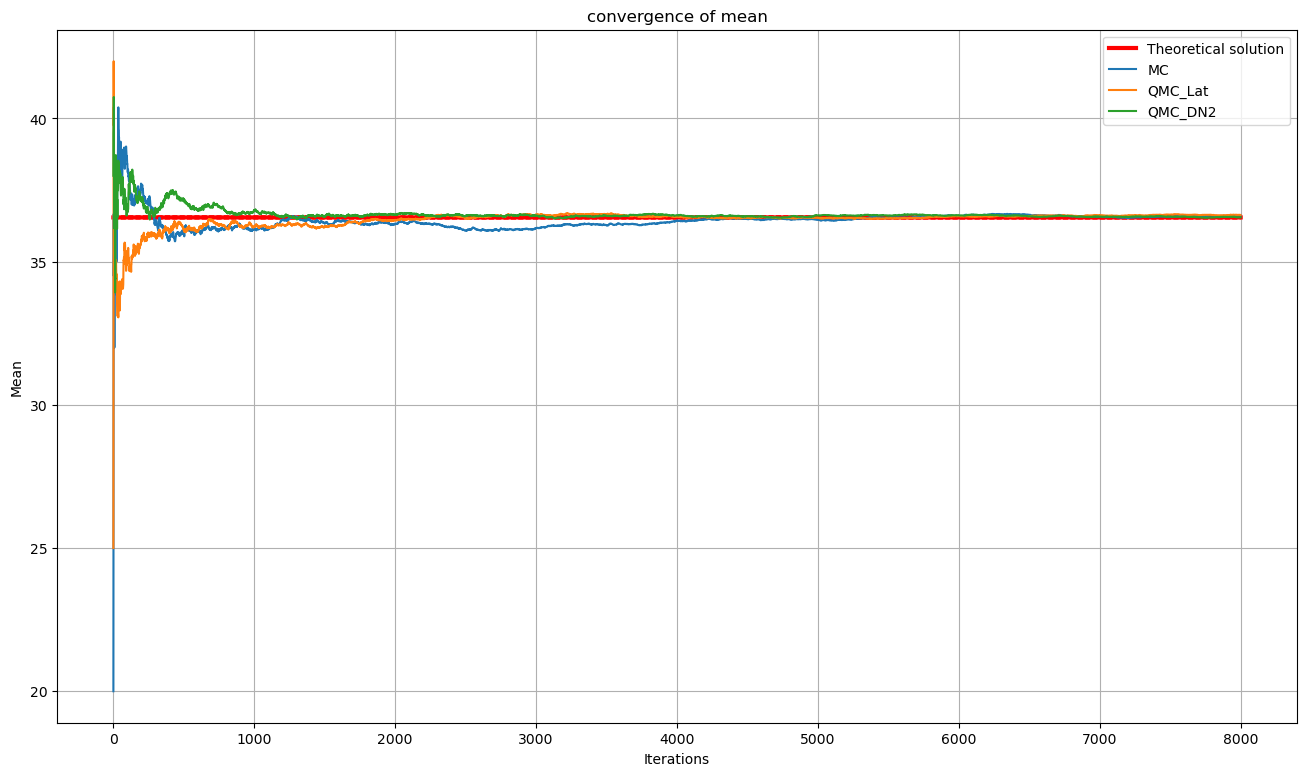

done


In [6]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

plt.plot(sol[:M], linewidth=3, color='red', label = 'Theoretical solution')
plt.plot(lower_bound[:M], linewidth=1, linestyle='--', color='red')
plt.plot(upper_bound[:M], linewidth=1, linestyle='--', color='red')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(mean_table[jj], label = rv_type)
plt.legend()   
plt.show()

print("done")

Here we plot the different histograms of all the solutions in all the scenarios in Logscale. The idea is to minimize the fluctuations in the first iteractions.

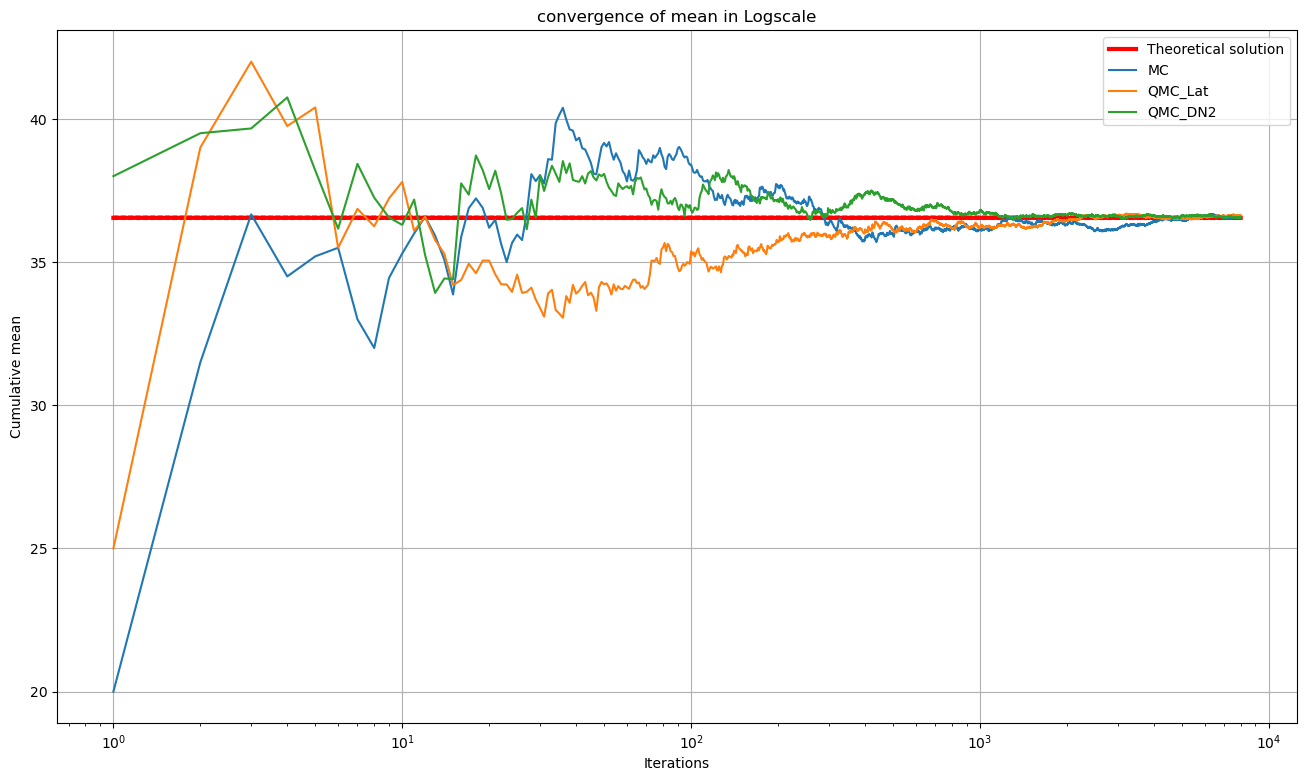

done


In [7]:
# plot of convergence in logscale
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean in Logscale")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cumulative mean")
plt.grid(True)

x_axis = np.linspace(1, M, M)

plt.plot(x_axis, sol[:M], linewidth=3, color='red', label = 'Theoretical solution')
plt.plot(x_axis, lower_bound[:M], linewidth=1, linestyle='--', color='red')
plt.plot(x_axis, upper_bound[:M], linewidth=1, linestyle='--', color='red')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(x_axis[:len(mean_table[jj])], mean_table[jj], label = rv_type)
plt.legend()   
plt.xscale('log')
plt.show()

print("done")

And here we plot the different histograms of all the solutions in all the scenarios. In the top left graphic we can see the same plot as before from iteration 0 to iteration 400.

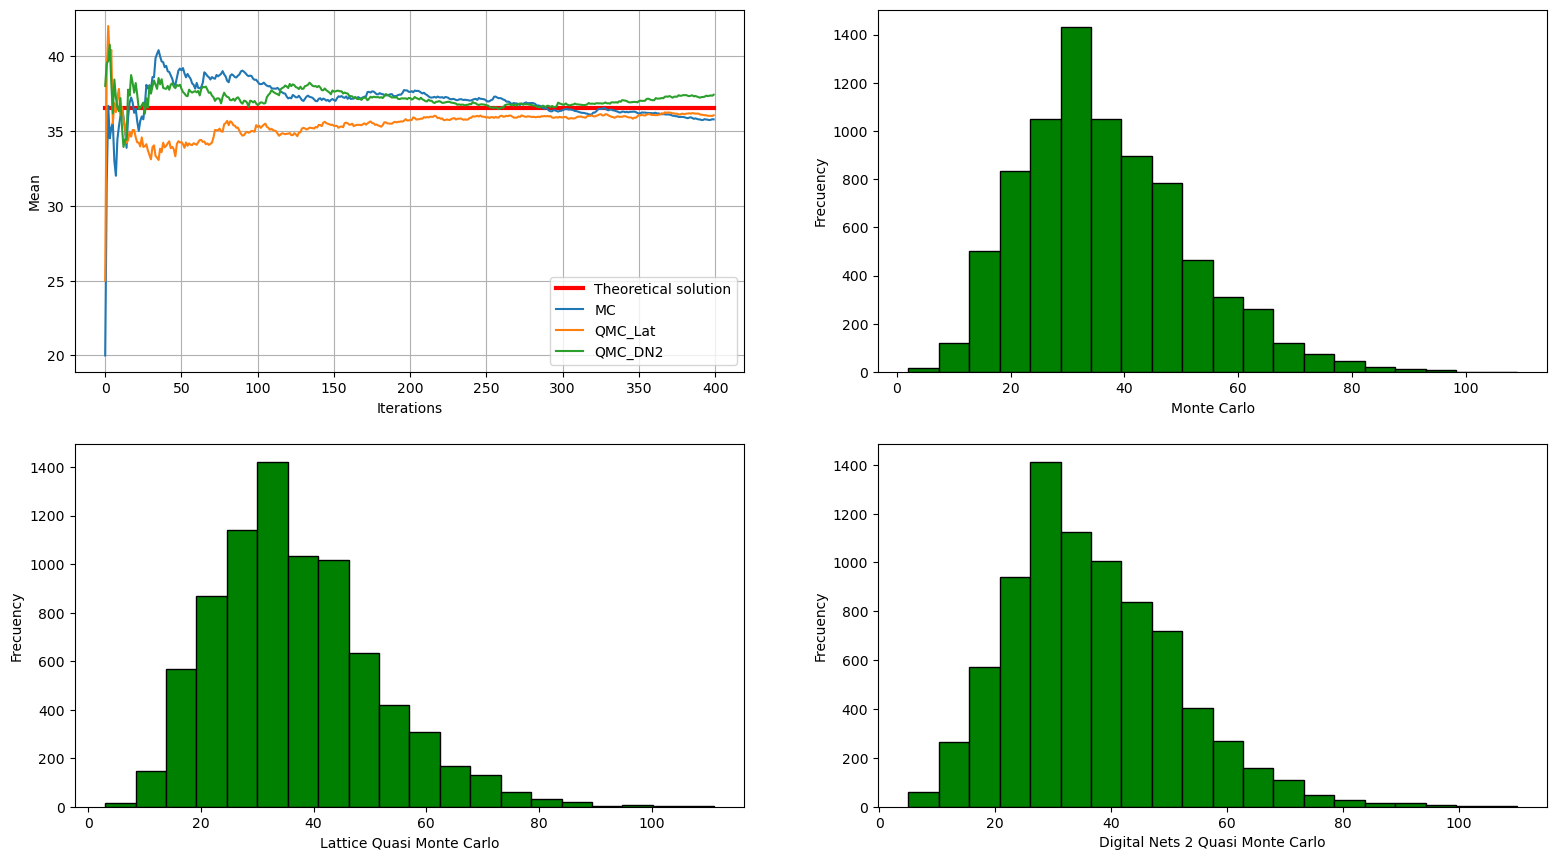

done


In [8]:
# Plot of Histograms
fig, ax = plt.subplots(figsize=[19, 16])

plt.subplot(3, 2, 1)
plt.xlabel("Iterations")
plt.ylabel("Mean")
plt.grid(True)

plt.plot(sol[0:400], linewidth=3, color='red', label = 'Theoretical solution')
plt.plot(lower_bound[0:400], linewidth=1, linestyle='--', color='red')
plt.plot(upper_bound[0:400], linewidth=1, linestyle='--', color='red')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(mean_table[jj][0 : 400], label = rv_type)
plt.legend()   
 
for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]

    plt.subplot(3, 2, jj+2)
    if rv_type == 'MC':
        plt.xlabel("Monte Carlo")    
    elif rv_type == 'QMC_Lat':
        plt.xlabel("Lattice Quasi Monte Carlo")
    elif rv_type == 'QMC_DN2':
        plt.xlabel("Digital Nets 2 Quasi Monte Carlo")
    elif rv_type == 'QMC_Lat_Batch':
        plt.xlabel("Lattice Quasi Monte Carlo with " + str(K) + " batches")
    elif rv_type == 'QMC_DN2_Batch':
        plt.xlabel("Digital Nets 2 Quasi Monte Carlo with " + str(K) + " batches")
    plt.ylabel("Frecuency")
    plt.hist(t_table[jj], bins=20, alpha=1, color="green", edgecolor='black', linewidth=1)
  
plt.show()

print("done")

Here we can see the first 200 iterations for the convergence plot.

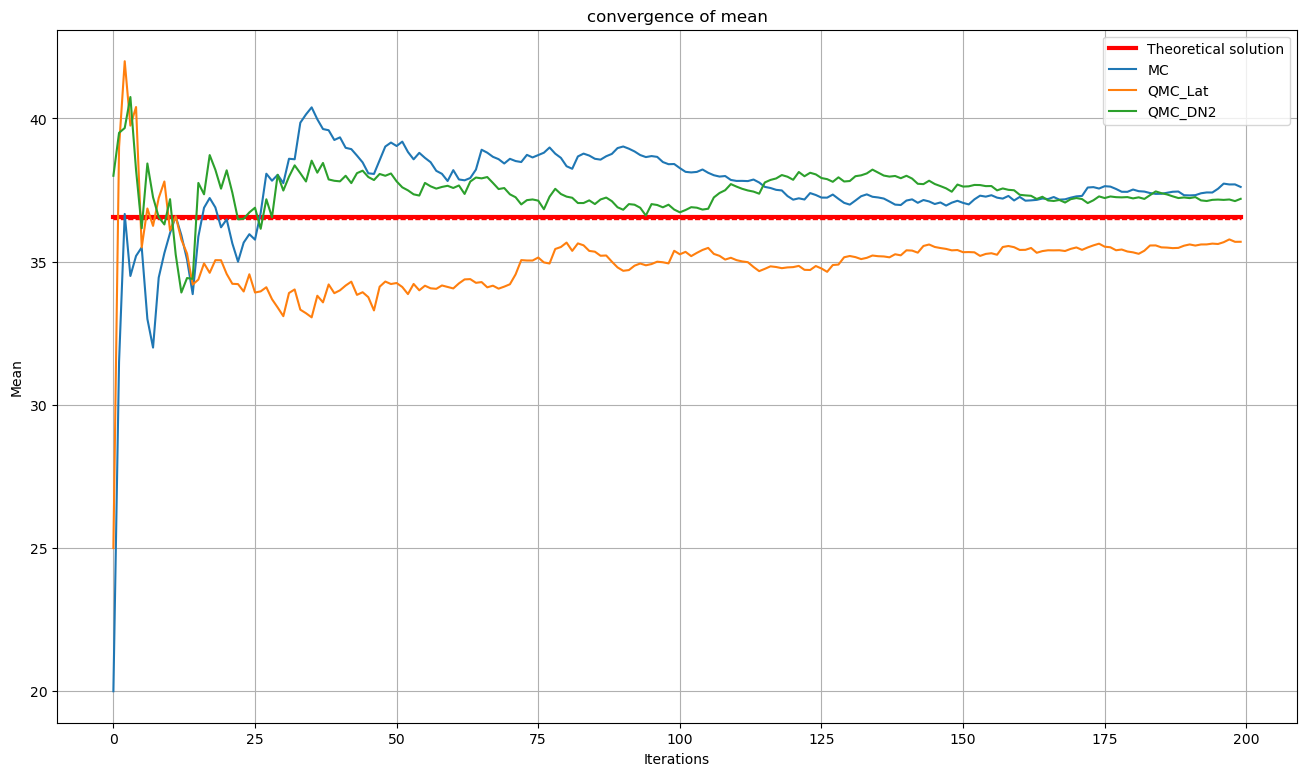

done


In [9]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

plt.plot(sol[0:200], linewidth=3, color='red', label = 'Theoretical solution')
plt.plot(lower_bound[0:200], linewidth=1, linestyle='--', color='red')
plt.plot(upper_bound[0:200], linewidth=1, linestyle='--', color='red')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(mean_table[jj][0:200], label = rv_type)
plt.legend()   
plt.show()

print("done")

And here we can see the iteration 25 to the 2025. It is made to avoid the initial peaks. In the first iterations is really probable to have solutions with errors of 20% or more, this can distorsionate the axis view of the plot. We can avoid that not plotting the first steps.

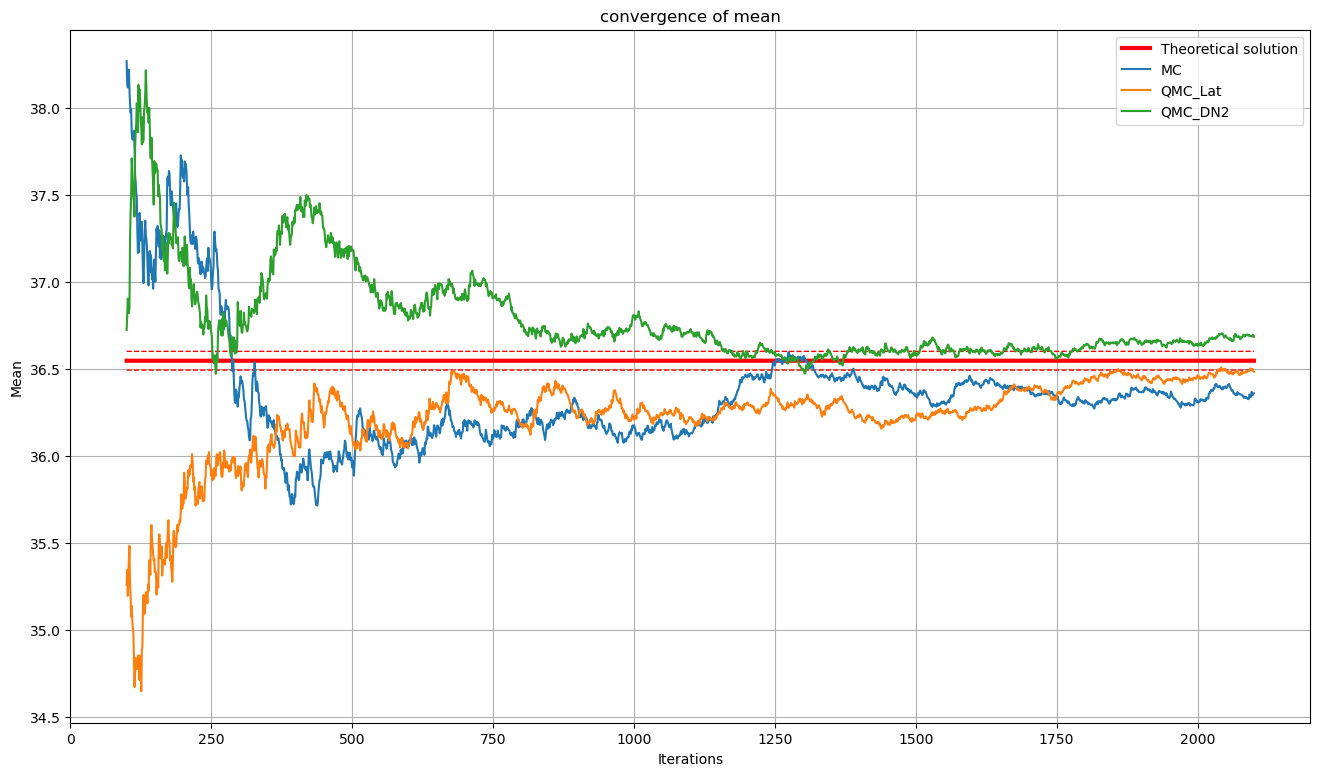

done


In [10]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

x_axis = np.linspace(100, 2100, 2000)

plt.plot(x_axis, sol[100:2100], linewidth=3, color='red', label = 'Theoretical solution')
plt.plot(x_axis, lower_bound[100:2100], linewidth=1, linestyle='--', color='red')
plt.plot(x_axis, upper_bound[100:2100], linewidth=1, linestyle='--', color='red')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(x_axis, mean_table[jj][100:2100], label = rv_type)
plt.legend()   
plt.show()

print("done")

Here we are going to try different baches for QMC methods.

In [11]:
K_array = [] # number of batches
mean_table = [] # cummulative average through scenarios
t_table = [] # all scenarios
M = 2400 # Number of scenarios
K_array = [1, 5, 10, 30, 60, 120] # Different size of batches

for kk in range(len(K_array)):

        K = K_array[kk] # number of batches

        rv_table = ['QMC_DN2_Batch', 'QMC_Lat_Batch']

        for jj in range(0, len(rv_table)):
            rv_type = rv_table[jj]

            [mean_aux, hist_aux] = queue(M, K, rv_type, 1)

            mean_table.append(mean_aux)
            t_table.append(hist_aux)
         
# adding a MC method to compare it
[mean_aux, hist_aux] = queue(M, K, 'MC', 1)

mean_table.append(mean_aux)
t_table.append(hist_aux)

print('done')

QMC Digital Net with 1 batches is: 36.59
QMC Lattice with 1 batches is: 36.32
QMC Digital Net with 5 batches is: 36.06
QMC Lattice with 5 batches is: 37.07
QMC Digital Net with 10 batches is: 36.58
QMC Lattice with 10 batches is: 35.86
QMC Digital Net with 30 batches is: 37.33
QMC Lattice with 30 batches is: 36.05
QMC Digital Net with 60 batches is: 36.59
QMC Lattice with 60 batches is: 35.54
QMC Digital Net with 120 batches is: 37.84
QMC Lattice with 120 batches is: 36.05
MC mean is: 37.00
done


Here we draw the convergence plot through scenarios from iteration 25 to iteration J_max (2400).

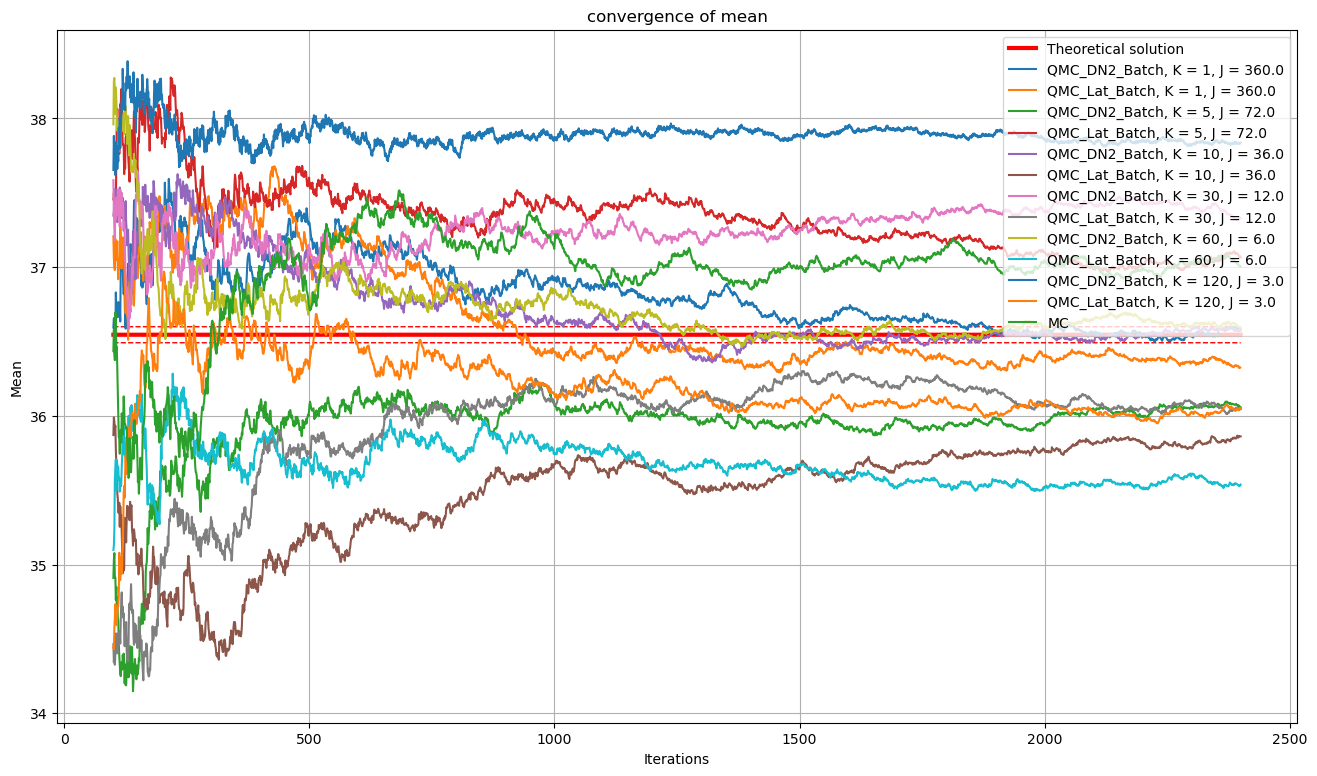

done


In [12]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

x_axis = np.linspace(100, M, M-100)

plt.plot(x_axis, sol[100:M], linewidth=3, color='red', label = 'Theoretical solution')
plt.plot(x_axis, lower_bound[100:M], linewidth=1, linestyle='--', color='red')
plt.plot(x_axis, upper_bound[100:M], linewidth=1, linestyle='--', color='red')

aux = 0
for kk in range(len(K_array)):
    
 
    for jj in range(0, len(rv_table)):
        rv_type = rv_table[jj]
        
        plt.plot(x_axis[0:len(mean_table[aux][100:M])], mean_table[aux][100:M], label = rv_table[jj] + ', K = ' + str(K_array[kk]) + ', J = ' + str(360/K_array[kk]))
        
        aux = aux + 1
        
plt.plot(x_axis, mean_table[-1][100:M], label = 'MC')
    
plt.legend(loc='upper right')
plt.show()

print('done')

The logical number of batches should be bewteen 10 (that means discrepancy sequences of 36 [360/10]) numbers and 36 (10 [360/36]).

In [16]:
K_array = [] # number of batches
mean_table = [] # cummulative average through scenarios
t_table = [] # all scenarios
M = 2400 # Number of scenarios
K_array = [10, 15, 20, 30] # Different size of batches

for kk in range(len(K_array)):

        K = K_array[kk] # number of batches

        rv_table = ['QMC_DN2_Batch', 'QMC_Lat_Batch']

        for jj in range(0, len(rv_table)):
            rv_type = rv_table[jj]

            [mean_aux, hist_aux] = queue(M, K, rv_type, 1)

            mean_table.append(mean_aux)
            t_table.append(hist_aux)
         
# adding a MC method to compare it
[mean_aux, hist_aux] = queue(M, K, 'MC', 1)

mean_table.append(mean_aux)
t_table.append(hist_aux)

print('done')

QMC Digital Net with 10 batches is: 36.64
QMC Lattice with 10 batches is: 36.57
QMC Digital Net with 15 batches is: 36.40
QMC Lattice with 15 batches is: 36.23
QMC Digital Net with 20 batches is: 36.90
QMC Lattice with 20 batches is: 36.75
QMC Digital Net with 30 batches is: 37.57
QMC Lattice with 30 batches is: 36.01
MC mean is: 36.45
done


Here we can see how they converge:

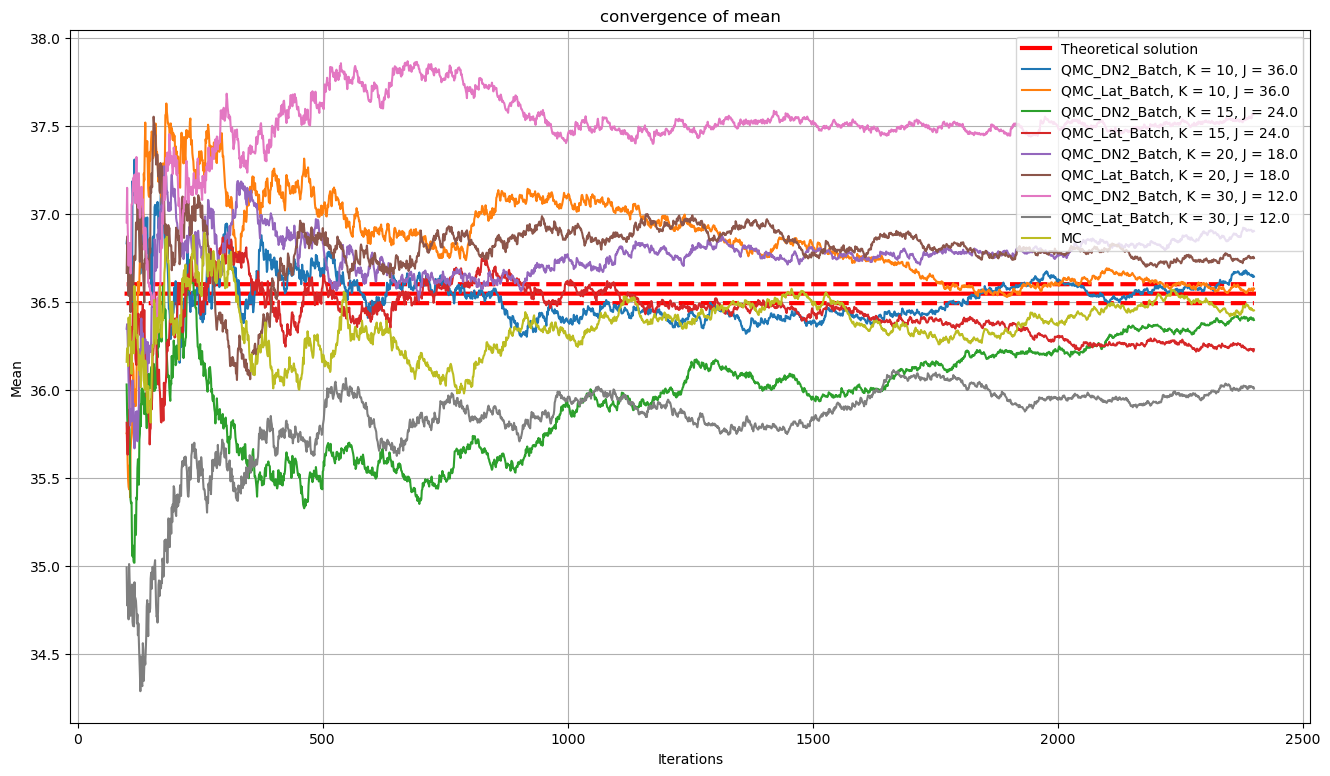

done


In [17]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

x_axis = np.linspace(100, M, M-100)

plt.plot(x_axis, sol[100:M], linewidth=3, color='red', label = 'Theoretical solution')
plt.plot(x_axis, lower_bound[100:M], linewidth=1, linestyle='--', color='red')
plt.plot(x_axis, upper_bound[100:M], linewidth=1, linestyle='--', color='red')

aux = 0
for kk in range(len(K_array)):
    
 
    for jj in range(0, len(rv_table)):
        rv_type = rv_table[jj]
        
        plt.plot(x_axis[:len(mean_table[aux][100:M])], mean_table[aux][100:M], label = rv_table[jj] + ', K = ' + str(K_array[kk]) + ', J = ' + str(360/K_array[kk]))
        
        aux = aux + 1
        
plt.plot(x_axis, mean_table[-1][100:M], label = 'MC')
    
plt.legend(loc='upper right')
plt.show()

print('done')

Here we can see a test to see how good are the QMC method solutions:

In [20]:
experiments = 30 # number of times the experiment is repeated, number of solutions registered
mean_register = []
rv_table = ['QMC_DN2_Batch', 'QMC_Lat_Batch']
for jj in range(0, len(rv_table)):
    mean_register.append([])
    for ii in range(experiments):
        mean_register[jj].append([])
    
K_array = [] # number of batches
mean_table = [] # cummulative average through scenarios
t_table = [] # all scenarios
M = 2400 # Number of scenarios
# K_array = [10, 15, 20, 30] # Different size of batches
K_array = [10, 12, 15, 18, 20, 24, 30, 36] # Different size of batches

for kk in range(len(K_array)):

    K = K_array[kk] # number of batches

    rv_table = ['QMC_DN2_Batch', 'QMC_Lat_Batch']

    for jj in range(0, len(rv_table)):
        rv_type = rv_table[jj]
        for ii in range(experiments):
            mean_register[jj][ii].append(queue(M, K, rv_type, 0)[0][-1])

        sol_register = np.mean(mean_register[jj]) # solution

        sol_std = np.std(mean_register[jj]) # std of the solution

        sol_range = 2.58*1.2*sol_std/np.sqrt(experiments) # length of the confidence semi interval

        print(f'The solution for {rv_table[jj]} with {K_array[kk]} bacthes is going to be: {sol_register:.2f} +/- {sol_range:.2f} with a 99% confidence interval')
    
print('done')

The solution for QMC_DN2_Batch with 10 bacthes is going to be: 36.57 +/- 0.24 with a 99% confidence interval
The solution for QMC_Lat_Batch with 10 bacthes is going to be: 36.52 +/- 0.18 with a 99% confidence interval
The solution for QMC_DN2_Batch with 12 bacthes is going to be: 36.54 +/- 0.23 with a 99% confidence interval
The solution for QMC_Lat_Batch with 12 bacthes is going to be: 36.54 +/- 0.18 with a 99% confidence interval
The solution for QMC_DN2_Batch with 15 bacthes is going to be: 36.58 +/- 0.27 with a 99% confidence interval
The solution for QMC_Lat_Batch with 15 bacthes is going to be: 36.54 +/- 0.18 with a 99% confidence interval
The solution for QMC_DN2_Batch with 18 bacthes is going to be: 36.57 +/- 0.26 with a 99% confidence interval
The solution for QMC_Lat_Batch with 18 bacthes is going to be: 36.56 +/- 0.18 with a 99% confidence interval
The solution for QMC_DN2_Batch with 20 bacthes is going to be: 36.56 +/- 0.28 with a 99% confidence interval
The solution for QM

## Real solution is between 36.5 and 36.6. Here all Lattice solutions are 36.5x +/- 0.2, but clearly they're closer to 35.53(???). Could it be because of a problem while doing the range of the C.I. and the normality assumption?